# Graph Visualization

The dataset being worked with is the Amazon Product Co-Purchasing Network, collected on June 1, 2003. It is provided by the Stanford Large Network Dataset Collection ([SNAP](https://snap.stanford.edu/data/)). The data can be briefly described as:

```
Network was collected by crawling Amazon website. It is based on Customers Who Bought This Item Also Bought feature of the Amazon website. If a product i is frequently co-purchased with product j, the graph contains a directed edge from i to j.
```

The data can be found from [here](https://snap.stanford.edu/data/amazon0601.html)

The goal will be to look into how one item influences what else is being purchased with it. 

## Import Packages

In [40]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx
import random

## Import Data File

The data file is a simple text file with its structure looking like the following:

<div>
<img src="https://github.com/hellojohncruz/DATA-620/blob/main/Graph%20Visualization/nodes.png?raw=true" width="500"/>
</div>

Reading the file at each line, we will ignore any header comments and the parse the data as a list of edges. 

In [2]:
# Read the file, skipping the header lines starting with '#'
with open("Amazon0601.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# Extract edges (skip commented lines)
edges = []
for line in lines:
    if not line.startswith("#"):  # Ignore comments
        parts = line.strip().split("\t")
        if len(parts) == 2:
            edges.append((int(parts[0]), int(parts[1])))

We can now see out list stored with tuples that show a **FromNodeId** and a **ToNodeId** pairing

In [3]:
edges[:5]

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

Lastly, the list will be converted into a pandas DataFrame

In [4]:
df_graph = pd.DataFrame(edges, columns=["from_node", "to_node"])
df_graph.head()

,from_node,to_node
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


## Data Wrangling 

There is no additional data cleaning required. 

## Exploratory Data Analysis

### Number of Node Pairings

We can see our dataset contains almost 3.4 million node pairings. 

In [5]:
pd.options.display.float_format = '{:.0f}'.format
df_graph.count()

from_node    3387388
to_node      3387388
dtype: int64

### Number of Unique IDs

What we can see from this is that we have over 402,000 unique IDs that end up being co-purchased with over 403,000 unique IDs. This makes sense where a customer could buy something that does not mean has a equal relationship of purchasing it in the opposite direction.

In [8]:
df_graph.nunique()

from_node    402439
to_node      403312
dtype: int64

In [9]:
pd.reset_option('display.float_format')

### Number of Node Connections

When we collectively count how many edges directly connect to a node, we can see that a node can have up to ten connections. As we look at the total number of nodes with these types of edge relationships, we vastly see that a majority of nodes have ten connections compared to other counts. 

In [15]:
pairs_df = df_graph.groupby('from_node')['to_node'].nunique().sort_values(ascending=False).reset_index().rename(columns = {'to_node':'number_of_connections'}).groupby('number_of_connections').agg('count').reset_index(drop=False).rename(columns = {'from_node':'total_nodes'})
pairs_df

,number_of_connections,total_nodes
0,1,12121
1,2,15925
2,3,16275
3,4,15475
4,5,14135
5,6,12827
6,7,11906
7,8,11370
8,9,13297
9,10,279108


<Axes: xlabel='number_of_connections', ylabel='total_nodes'>

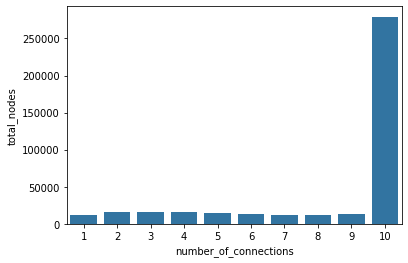

In [16]:
sns.barplot(data = pairs_df, x = 'number_of_connections', y = 'total_nodes')

## Creating our NetworkX Graph

In [43]:
df_graph_sorted = df_graph.sort_values('from_node')
df_graph_filtered = df_graph_sorted[:1000]

In [44]:
G = nx.from_pandas_edgelist(df_graph_filtered, "from_node", "to_node")

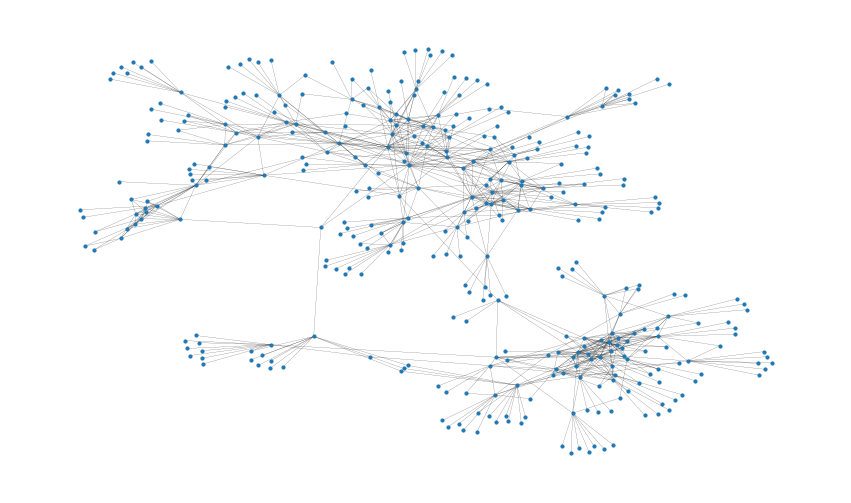

In [45]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=123), ax=ax, **plot_options)

In [46]:
top_connections = max(dict(G.degree()).items(), key = lambda x : x[1])
print(f"Top node (highest degree): {top_connections}")

top_centrality = max(nx.betweenness_centrality(G), key=nx.betweenness_centrality(G).get)
print(f"Top node (highest betweenness centrality): {top_centrality}")

Top node (highest degree): (44, 28)
Top node (highest betweenness centrality): 105


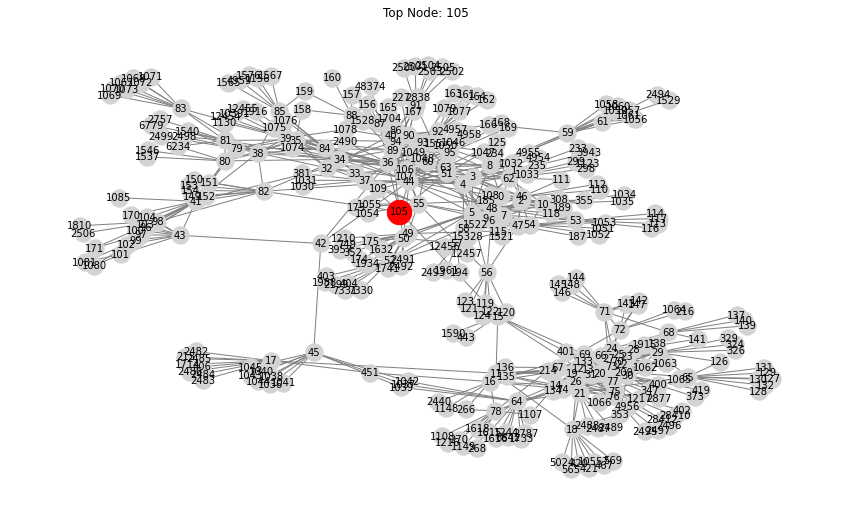

In [47]:
# Set a seed for consistent layout
pos = nx.spring_layout(G, seed=123)  # Ensure the same layout every time

# Draw the graph
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")

nx.draw(G, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=300, font_size=10)

# Highlight the top node
nx.draw_networkx_nodes(G, pos, nodelist=[top_centrality], node_color="red", node_size=600)

plt.title(f"Top Node: {top_centrality}")
plt.show()

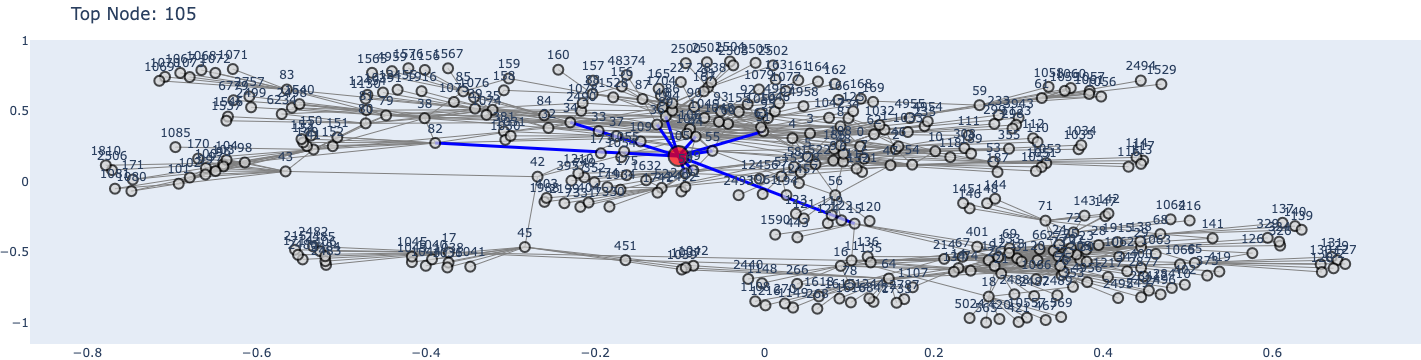

In [48]:
# Set seeds for reproducibility
random.seed(123)
np.random.seed(123)

# Get node positions using spring layout (set seed for reproducibility)
pos = nx.spring_layout(G, seed=123)  

# Create edge traces with highlighting
edge_x, edge_y = [], []
highlight_x, highlight_y = [], []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]

    if top_centrality in edge:  # Highlight edges connected to top node
        highlight_x.extend([x0, x1, None])
        highlight_y.extend([y0, y1, None])
    else:
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

# Normal edges (gray)
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color="gray"),
    mode="lines",
    hoverinfo="none",
)

# Highlighted edges (blue)
highlight_edge_trace = go.Scatter(
    x=highlight_x,
    y=highlight_y,
    line=dict(width=3, color="blue"),
    mode="lines",
    hoverinfo="none",
)

# Create node traces
node_x, node_y = [], []
node_colors = []
node_sizes = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

    # Highlight top node
    if node == top_centrality:
        node_colors.append("red")
        node_sizes.append(20)
    else:
        node_colors.append("lightgray")
        node_sizes.append(10)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    marker=dict(
        size=node_sizes,
        color=node_colors,
        line=dict(width=2, color="black"),
    ),
    text=[str(n) for n in G.nodes()],
    textposition="top center",
    hoverinfo="text",
)

# Create interactive Plotly figure
fig = go.Figure(data=[edge_trace, highlight_edge_trace, node_trace])

# Update layout for interactivity
fig.update_layout(
    showlegend=False,
    hovermode="closest",
    margin=dict(b=0, l=0, r=0, t=40),
    title=f"Top Node: {top_centrality}",
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
)

# Show the figure
fig.show()

## Conclusion

We have demonstrated how to transform our data from pandas into different formats to display a network. However, there is still much more to explore, even simple tasks like labeling nodes can be done more effectively. With further research, we can use techniques such as centrality measurements to identify and label the most important nodes while ignoring less significant ones on the fringes of the graph.

metadata https://snap.stanford.edu/data/amazon-meta.html